In [1]:
import numpy as np
import pandas as pd
import re
import dill as pickle
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Load the job statistics

def parse_time(timestr):
    if not isinstance(timestr, str):
        return 0
    expr = re.compile(r'(?:(\d+)-)?(?:(\d+):)?(?:(\d+):)?(\d+)')
    groups = expr.match(timestr).groups()
    days, hrs, mins, secs = map(lambda s: int(s) if s is not None else 0, groups)
    return secs + 60*(mins + 60*(hrs + 24*days))

def load_df(filen='job-statistics.csv'):
    data = pd.read_csv(filen)
    data = data.dropna()
    data['walltime'] = data['Actual Walltime'].apply(parse_time)
    return data

job_stats = load_df()

In [3]:
job_stats['Job Name'][:500]

0            atr-thomas-augmented-random-activ_f-1.0-500
1          atr-thomas-standard-continue-activ_f-2.0-2000
2          atr-rossler-augmented-random-activ_f-0.1-2000
3            atr-thomas-standard-random-activ_f-2.0-1000
4            atr-thomas-standard-random-activ_f-0.1-1000
                             ...                        
495    results-thomas-standard-continue-activ_f-1.0-2000
496       thomas-standard-random-random-1.0-2000-results
497    results-rossler-standard-continue-random-1.0-2000
498    results-rossler-augmented-random-activ_f-2.0-1000
499       results-thomas-standard-random-random-0.1-1000
Name: Job Name, Length: 500, dtype: object

In [4]:
# Clean up parts we don't want
cleaned = job_stats.copy()

In [5]:
cleaned = cleaned[cleaned['Job State'] == 'COMPLETE']

In [6]:
def parse_name(name):
    if not isinstance(name, str):
        return None
    expr = re.compile(r'(?:(?:results-?)|(?=.*-results))([a-z]+)-([a-z]+)-([a-z]+)-([a-z_]+)-([0-9\.]+)-([0-9]+)')
    match = expr.match(name)
    if match:
        return match.groups()
    else:
        return None

cleaned['name'] = cleaned['Job Name'].apply(parse_name)
cleaned.dropna(inplace=True)

In [7]:
def get_overlap(name_t):
    """Returns the overlap used by that parameter set"""
    augtype = name_t[1]
    if augtype == 'standard':
        return 0
    else:
        filen = 'results/{}-{}-{}-{}-d{}-n{}.pkl'.format(*name_t)
        with open(filen, 'rb') as file:
            experiment, params = pickle.load(file)
        return params['overlap']

cleaned['overlap'] = cleaned['name'].apply(get_overlap)

In [13]:
cleaned['system'] = cleaned['name'].apply(lambda x:x[0])
cleaned['n'] = cleaned['name'].apply(lambda x:x[-1])
cleaned['d'] = cleaned['name'].apply(lambda x:x[-2])
cleaned[['system', 'walltime', 'n', 'd', 'overlap']]

,system,walltime,n,d,overlap
26,rossler,492751,2000,2.0,0.95
135,rossler,203297,2000,1.0,0.00
136,rossler,177813,2000,0.1,0.95
141,thomas,249310,2000,1.0,0.00
142,thomas,217770,2000,0.1,0.00
143,rossler,104214,2000,0.1,0.20
144,thomas,209845,2000,2.0,0.00
145,thomas,201461,1000,0.1,0.60
146,thomas,188855,2000,1.0,0.00
147,thomas,67424,2000,0.1,0.10


In [9]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 26 to 539
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job ID             53 non-null     int64  
 1   Job Name           53 non-null     object 
 2   CPUs Allocated     53 non-null     int64  
 3   CPU Efficiency     53 non-null     float64
 4   Memory Efficiency  53 non-null     float64
 5   Actual Walltime    53 non-null     object 
 6   Time Job Finished  53 non-null     object 
 7   Job State          53 non-null     object 
 8   walltime           53 non-null     int64  
 9   name               53 non-null     object 
 10  overlap            53 non-null     float64
 11  system             53 non-null     object 
 12  n                  53 non-null     object 
dtypes: float64(3), int64(3), object(7)
memory usage: 5.8+ KB


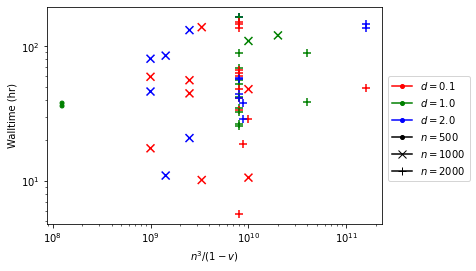

In [15]:
# Plot
ns = cleaned['n'].apply(int).to_numpy()
degrees = cleaned['d'].apply(float).to_numpy()
overlaps = cleaned['overlap'].to_numpy()
walltimes = cleaned['walltime'].to_numpy()
systems = cleaned['system'].to_numpy()

colors = np.array(['r','g','b'])
symbols = np.array(['.','x','+'])

system_unique, color_idx = np.unique(degrees, return_inverse=True)
n_unique, symbol_idx = np.unique(ns, return_inverse=True)

legend_elements = [
    Line2D([0], [0], marker='.', color=c, label=f'$d={sys}$',#sys.capitalize(),
           markerfacecolor=c, markersize=8)
    for c,sys in zip(colors, system_unique)
] + [
    Line2D([0], [0], marker=m, color='k', label=f'$n={n}$', markerfacecolor='k', markersize=8, linestyle=None)
    for m,n in zip(symbols, n_unique)
]

plt.figure()
for i,n in enumerate(n_unique):
    plt.scatter(ns**3 / (1-overlaps),
                walltimes/3600, s=(ns == n)*64, c=colors[color_idx], marker=symbols[i])
plt.xlabel('$n^3/(1-v)$')
plt.ylabel('Walltime (hr)')
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=legend_elements, loc=(1.02,0.2))
plt.show()